In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, 
                            homogeneity_score, 
                            completeness_score, 
                            v_measure_score, 
                            f1_score)
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

In [2]:
# DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels,  # прямо указали х и у
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

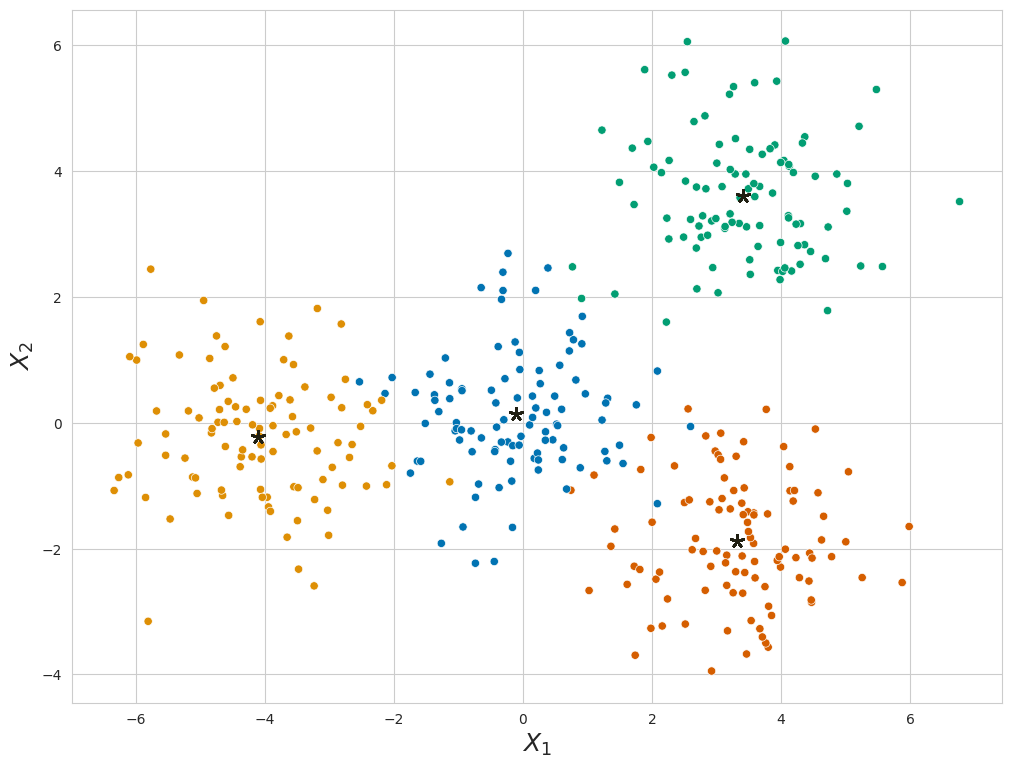

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """

        distances = []
        for centroid in self.centroids:
            distances.append(self._calculate_distance(X, centroid))
        distances = np.concatenate(distances, axis=1)
        cluster_labels = np.argmin(distances, axis=1)
            
        return cluster_labels
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.linalg.norm(X - centroid, axis=1, keepdims=True)
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

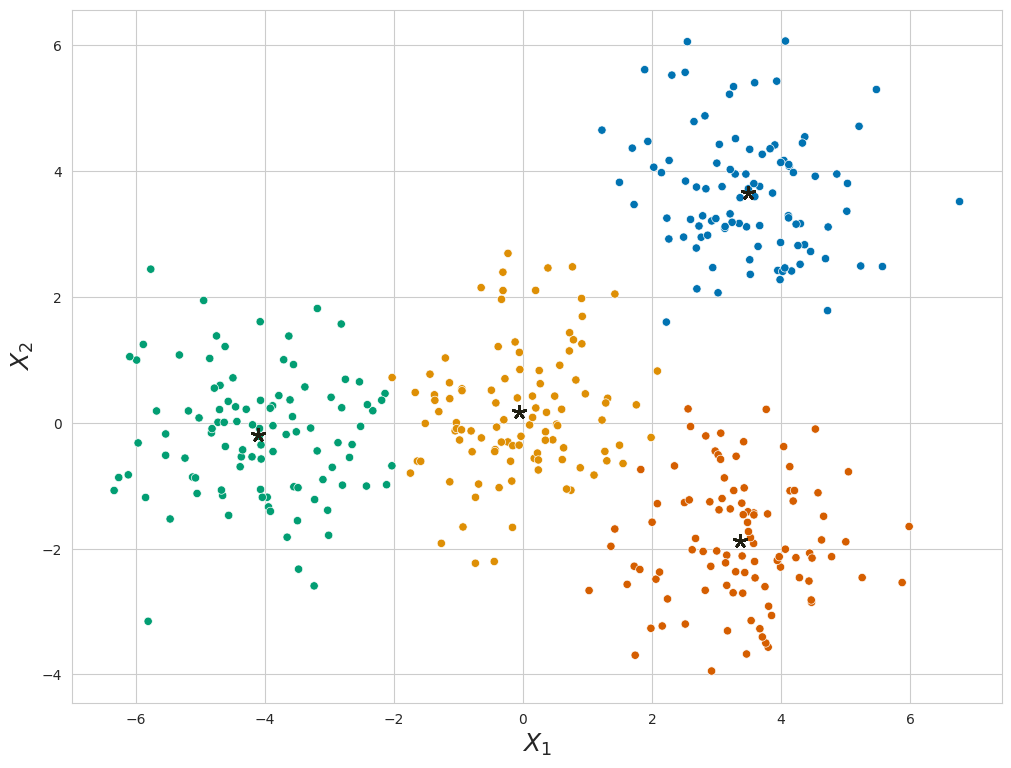

In [7]:
# Различные способы инициализации центроидов
# random

kmeans_random = MyKMeans(n_clusters=4, init="random", max_iter=20, visualize=True) # инициализация
kmeans_random.fit(X)  # обучение
pred_labels_random = kmeans_random.predict(X)  # предсказание

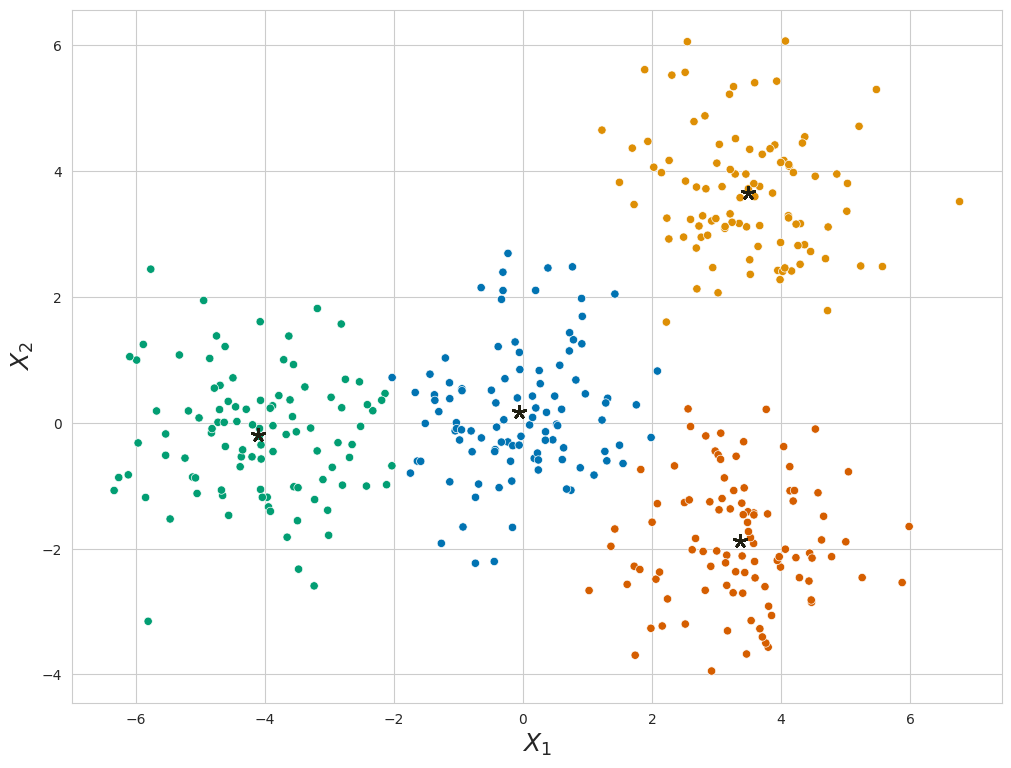

In [8]:
# sample

kmeans_sample = MyKMeans(n_clusters=4, init="sample", max_iter=20, visualize=True)
kmeans_sample.fit(X)
pred_labels_sample = kmeans_sample.predict(X)

In [9]:
#одна из метрик качества кластеризации, силуэт

silhouette_random = silhouette_score(X, pred_labels_random)
print(f'Silhouette_random = {silhouette_random}')

silhouette_sample = silhouette_score(X, pred_labels_sample)
print(f'Silhouette_sample = {silhouette_sample}')

Silhouette_random = 0.5643117184043004
Silhouette_sample = 0.5643117184043004


In [10]:
# Cилуэт варьируется от -1 до 1.  
# Высокое значение силуэта указывают на то, что объекты внутри кластера похожи друг на друга и отличаются от объектов в других кластерах.  
# Значения близкие к 0 говорят о том, что кластеры перекрываются.  
# Отрицательные значения могут указывать на то, что объекты неправильно распределены по классам.

In [11]:
# В данном случае мы получили одинаковые значение силуэтов, значит между выбранными способами инициализации центроидов нет разницы, оба работают примерно одинаково.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [12]:
data = load_digits()
X, y = data.data, data.target

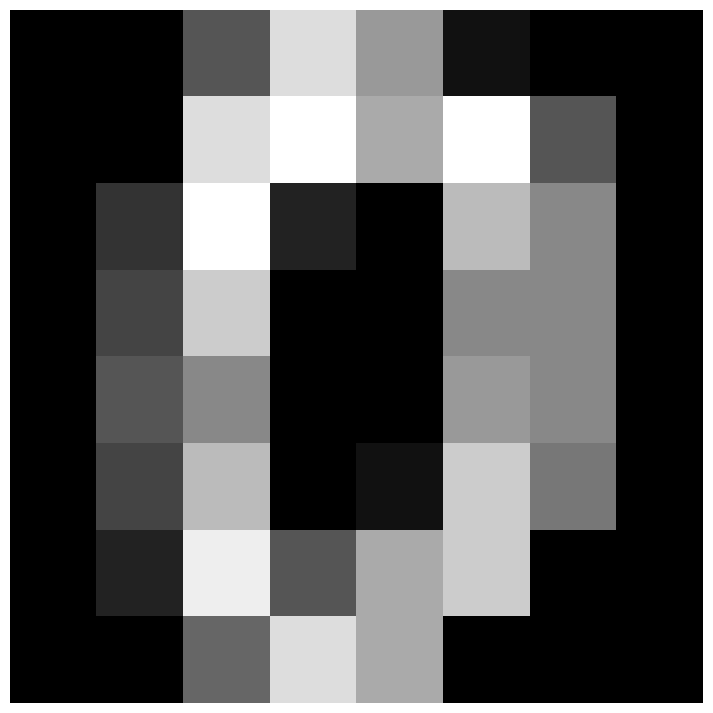

In [13]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [14]:
def algorithm_selection(X, distances, algorithms, metrics, n=5, y=None):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
        :param n: количество кластеров
        :param y: метки классов
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """    
    compare_results = []
    
    # перебираем все возможные комбинации метрик расстояния и алгоритмов
    for dist in distances:
        for algorithm in algorithms:
            cluster_model = AgglomerativeClustering(n_clusters=n, affinity=dist, linkage=algorithm)
            labels = cluster_model.fit_predict(X)

            result = {
                'distance': dist,
                'linkage': algorithm,
                'homogeneity': homogeneity_score(y, labels) if 'homogeneity' in metrics else None,
                'completeness': completeness_score(y, labels) if 'completeness' in metrics else None,
                'v_measure': v_measure_score(y, labels) if 'v_measure' in metrics else None,
                'silhouette': silhouette_score(X, labels) if 'silhouette' in metrics else None
            }

            compare_results.append(result)

    return pd.DataFrame(compare_results).dropna(axis=1)


In [15]:
distances = ['euclidean', 'manhattan', 'cosine', 'minkowski', 'chebyshev']
algorithms = ['average', 'single', 'complete']
metrics = ['homogeneity', 'completeness', 'v_measure', 'silhouette']

In [16]:
compare_dataframe = algorithm_selection(X, distances, algorithms, metrics, y=y)

In [17]:
# чтобы выбрать наилучший способ кластеризации, нужно выбрать комбинации с наибольшим значением силуэта (и желательно гомогенности, полноты и v-значения).

compare_dataframe.sort_values('silhouette', ascending=False)

distance   linkage  homogeneity  completeness  v_measure  silhouette
3   manhattan   average     0.469619      0.768695   0.583041    0.123602
5   manhattan  complete     0.418758      0.643104   0.507232    0.115576
12  chebyshev   average     0.473193      0.867583   0.612383    0.113559
0   euclidean   average     0.359987      0.675336   0.469636    0.111655
9   minkowski   average     0.359987      0.675336   0.469636    0.111655
6      cosine   average     0.382869      0.819737   0.521953    0.101582
2   euclidean  complete     0.426532      0.631284   0.509092    0.099638
11  minkowski  complete     0.426532      0.631284   0.509092    0.099638
8      cosine  complete     0.393480      0.625386   0.483040    0.092778
13  chebyshev    single     0.003336      0.289592   0.006595   -0.043123
7      cosine    single     0.002245      0.273460   0.004454   -0.085209
4   manhattan    single     0.002259      0.275133   0.004481   -0.097322
1   euclidean    single     0.002259      0.275133   0.004481   -0.115121
10  minkowski    single     0.002259      0.275133   0.004481   -0.115121
14  chebyshev  complete     0.036485      0.445819   0.067450   -0.136347

In [18]:
# Т.о., по параметрам лучше всего себя показали метрики расстояний manhattan и chebyshev, а алгоритмы -- average и complete.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [19]:
fc_data = pd.read_csv("../data_folder/raw_data/flow_c_data.csv", index_col=0)
                      
# fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [20]:
data_types_info = "Датасет содержит следующие колонки с соответствующими типами данных:\n" \
                  f"{fc_data.dtypes}"
statistics_info = "Статистические показатели по каждой колонке указаны ниже:\n" \
                  f"{fc_data.describe()}"

print(f"Всего в датасете {len(fc_data.index)} строк и {len(fc_data.columns)} колонок; {fc_data.isna().sum().sum()} пропущенных значений.")
print("\n" + "-"*50 + "\n")

print(data_types_info)
print("\n" + "-"*50 + "\n")

print(statistics_info)
print("\n" + "-"*50 + "\n")

Всего в датасете 10000 строк и 9 колонок; 0 пропущенных значений.

--------------------------------------------------

Датасет содержит следующие колонки с соответствующими типами данных:
FSC-A     float64
SSC-A     float64
HLA-DR    float64
CD3       float64
CD45      float64
CD14      float64
CD56      float64
CD19      float64
CD11c     float64
dtype: object

--------------------------------------------------

Статистические показатели по каждой колонке указаны ниже:
              FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313    

In [21]:
# В датасете содержится информация о 10000 клеток, описаны 8 признаков (т.к. FSC-A и SSC-A оба говорят о размере клеток, хоть и разными показателями)

In [22]:
# Посмотрим на выбросы

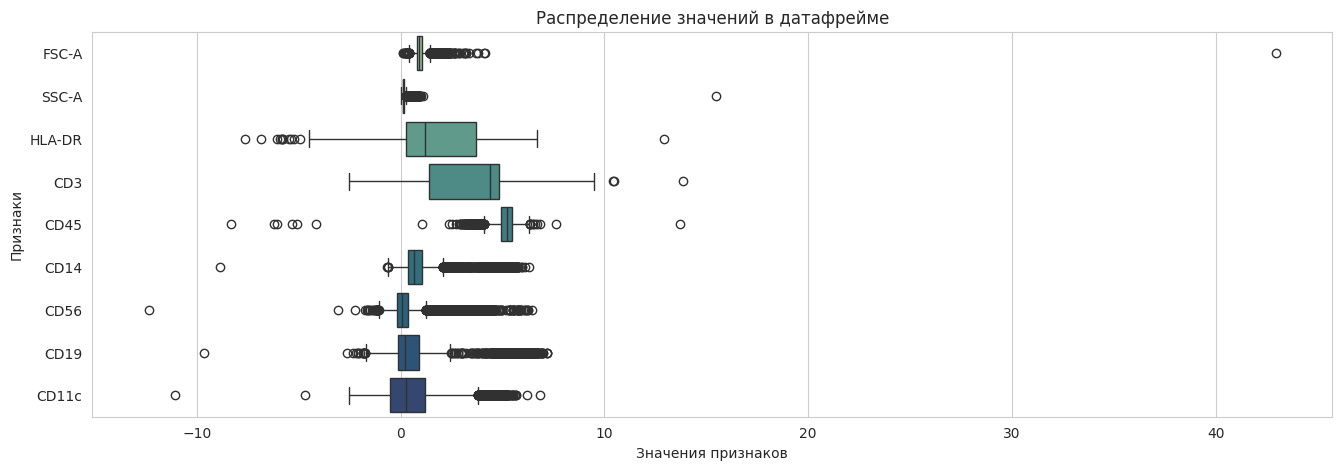

In [23]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=fc_data, orient="h", palette="crest")
plt.title('Распределение значений в датафрейме')
plt.xlabel('Значения признаков')
plt.ylabel('Признаки')

plt.show()

In [24]:
# Визуально кажется, что выбросы есть в колонках FSC-A, SSC-A, CD14, CD56, CD19, CD11c.  
# В FSC-A и SSC-A удалим максимальные значения, а в CD14, CD56, CD19, CD11c -- минимальные.

In [25]:
outliers = [np.argmax(fc_data['FSC-A']), np.argmax(fc_data['SSC-A']), 
            np.argmin(fc_data['CD14']), np.argmin(fc_data['CD56']), 
            np.argmin(fc_data['CD19']), np.argmin(fc_data['CD11c'])]

In [26]:
fc_data_new = fc_data.drop(outliers, axis=0, inplace=False)

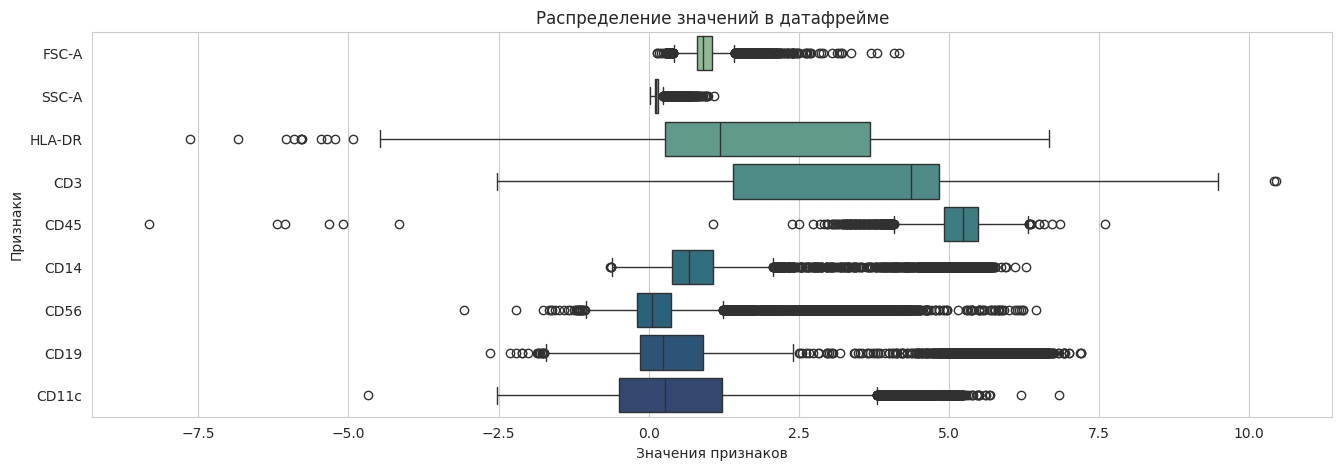

In [27]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=fc_data_new, orient="h", palette="crest")
plt.title('Распределение значений в датафрейме')
plt.xlabel('Значения признаков')
plt.ylabel('Признаки')

plt.show()

In [28]:
fc_data_new.describe()

FSC-A        SSC-A       HLA-DR          CD3         CD45  \
count  9999.000000  9999.000000  9999.000000  9999.000000  9999.000000   
mean      0.958259     0.163885     1.790463     3.279335     5.168991   
std       0.271388     0.113998     2.024310     2.109540     0.511184   
min       0.144786     0.021657    -7.634172    -2.517639    -8.329666   
25%       0.798777     0.105550     0.275008     1.401906     4.922219   
50%       0.908554     0.130528     1.193696     4.373500     5.234026   
75%       1.051959     0.162526     3.696455     4.842191     5.481168   
max       4.164550     1.085003     6.678981    10.452256     7.612352   

              CD14         CD56         CD19        CD11c  
count  9999.000000  9999.000000  9999.000000  9999.000000  
mean      1.098176     0.413500     1.220769     0.571064  
std       1.372355     1.170075     2.282836     1.497991  
min      -0.643408    -3.079160    -2.639452    -4.670057  
25%       0.389761    -0.195916    -0.146814    -0.498655  
50%       0.672971     0.053295     0.244182     0.272462  
75%       1.065191     0.378595     0.908439     1.220606  
max       6.294236     6.461899     7.208721     6.840864

In [29]:
# Стало немного лучше

In [30]:
# 1. Cleaning +
# 2. Imputation + (нет NA)
# 3. Scale (на очереди)
# 4. Reduction

In [31]:
scaler = StandardScaler()
fc_data_new_scaled = scaler.fit_transform(fc_data_new)
fc_data_final = pd.DataFrame(fc_data_new_scaled, columns=fc_data_new.columns)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [32]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

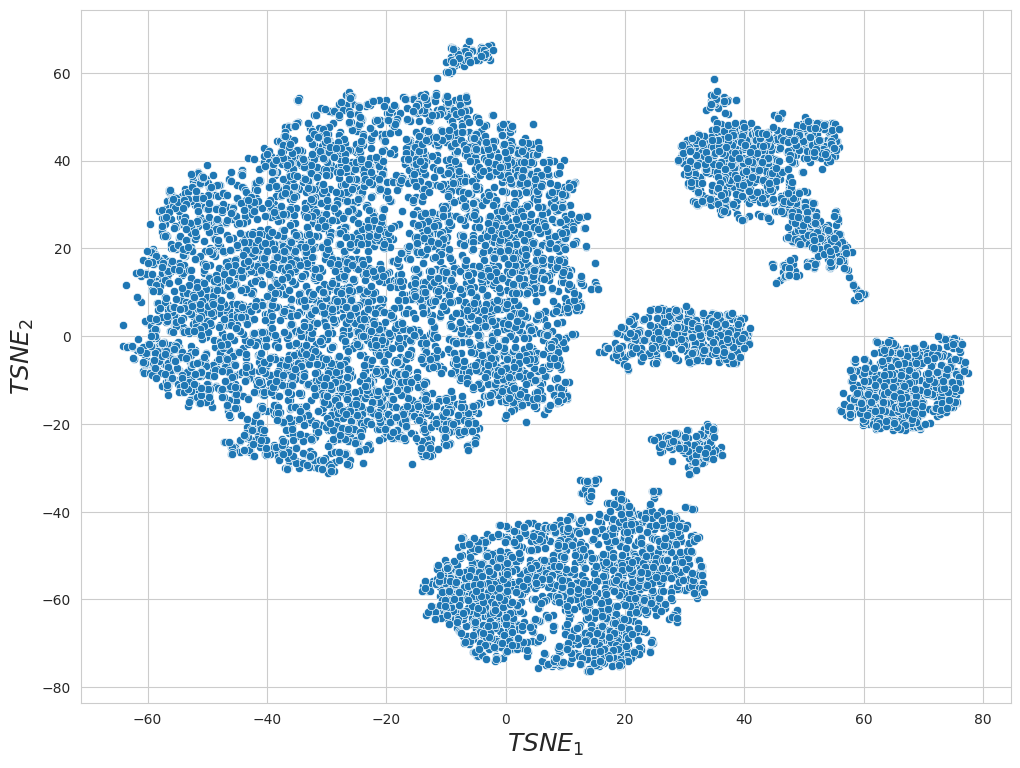

In [33]:
tsne_res = plot_tsne(fc_data_final)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [34]:
# K-means

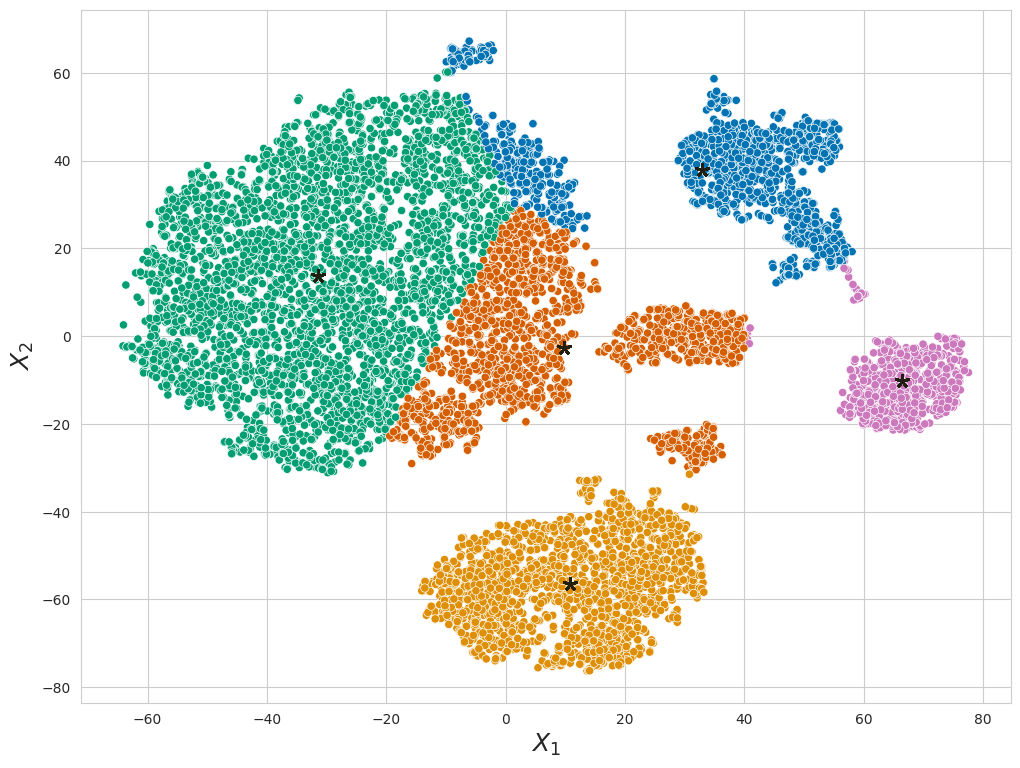

Silhouette score for K-means: 0.23879256556376294




In [35]:
# помним, что между random и sample особой разницы не увидели

fc_kmeans_sample = MyKMeans(n_clusters=5, init="sample", max_iter=5, visualize=True)  # снизили итерации до 5, т.к. ну оочень долго
fc_kmeans_sample.fit(tsne_res)
fc_pred_sample = fc_kmeans_sample.predict(tsne_res)

silhouette_fc_kmeans = silhouette_score(fc_data_final, fc_pred_sample)
print(f"Silhouette score for K-means: {silhouette_fc_kmeans}")
print("\n")

In [36]:
# Agglomaretive Clustering

In [37]:
distances = ['euclidean', 'manhattan', 'cosine', 'minkowski', 'chebyshev']
algorithms = ['average', 'single', 'complete']
metrics = ['silhouette']  # берем только метрику, где не нужен y 

In [38]:
fc_data_final_compare = algorithm_selection(fc_data_final, distances, algorithms, metrics, n=5)
fc_data_final_compare.sort_values(by='silhouette', ascending=False)

distance   linkage  silhouette
1   euclidean    single    0.594477
10  minkowski    single    0.594477
12  chebyshev   average    0.583089
4   manhattan    single    0.580860
0   euclidean   average    0.578083
9   minkowski   average    0.578083
13  chebyshev    single    0.574163
3   manhattan   average    0.510467
6      cosine   average    0.486464
14  chebyshev  complete    0.430183
5   manhattan  complete    0.370700
2   euclidean  complete    0.341479
11  minkowski  complete    0.341479
8      cosine  complete    0.119284
7      cosine    single   -0.370690

In [39]:
# euclidean	- single - 0.594477
# визуально не оно

fc_aggl_1 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
predicted_fc_aggl_1 = fc_aggl_1.fit_predict(fc_data_final)

Silhouette score: 0.5944774728340984


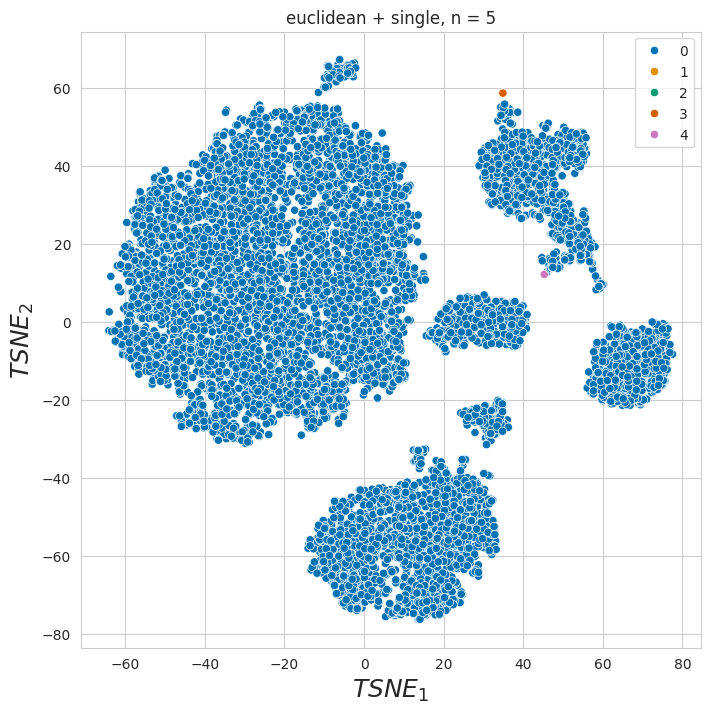

In [40]:
plt.figure(figsize=(8, 8))
plt.title('euclidean + single, n = 5')
tsne_res_1 = plot_tsne(fc_data_final, color=predicted_fc_aggl_1)

silhouette_1 = silhouette_score(fc_data_final, predicted_fc_aggl_1)
print(f'Silhouette score: {silhouette_1}')

In [41]:
# chebyshev - average - 0.583089
# визуально не оно [2]

fc_aggl_2 = AgglomerativeClustering(n_clusters=5, affinity='chebyshev', linkage='average')
predicted_fc_aggl_2 = fc_aggl_2.fit_predict(fc_data_final)

Silhouette score: 0.583088992554482


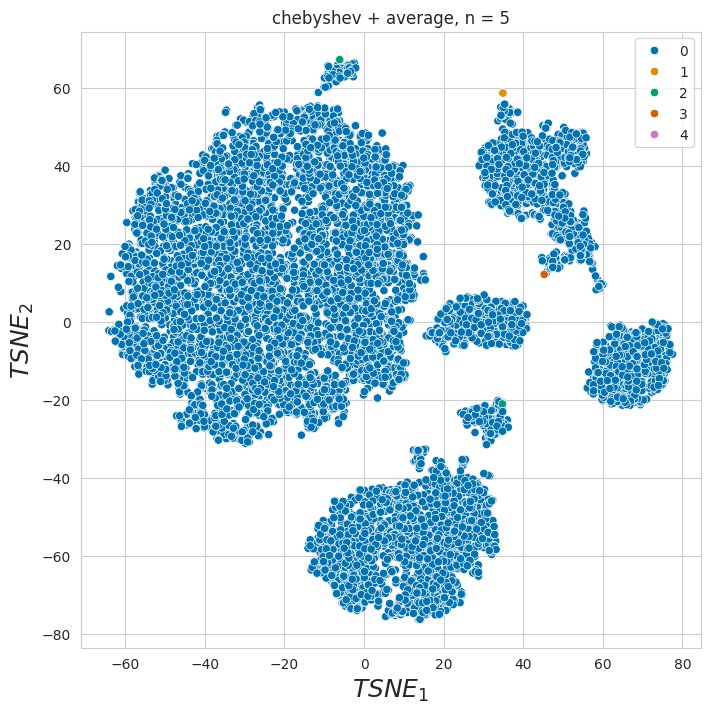

In [42]:
plt.figure(figsize=(8, 8))
plt.title('chebyshev + average, n = 5')
tsne_res_2 = plot_tsne(fc_data_final, color=predicted_fc_aggl_2)

silhouette_2 = silhouette_score(fc_data_final, predicted_fc_aggl_2)
print(f'Silhouette score: {silhouette_2}')

In [43]:
# manhattan - single - 0.580860
# визуально не оно [3]

fc_aggl_3 = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='single')
predicted_fc_aggl_3 = fc_aggl_3.fit_predict(fc_data_final)

Silhouette score: 0.5808603433524799


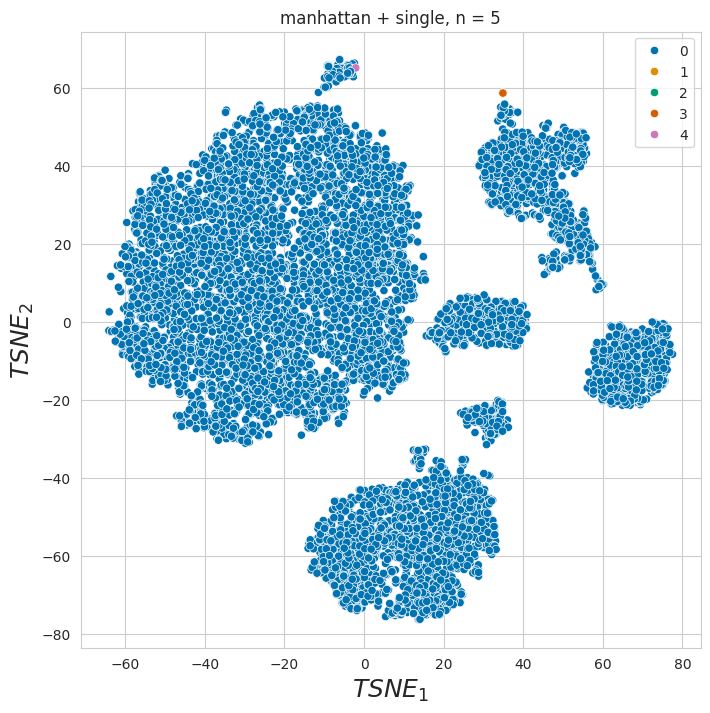

In [44]:
plt.figure(figsize=(8, 8))
plt.title('manhattan + single, n = 5')
tsne_res_3 = plot_tsne(fc_data_final, color=predicted_fc_aggl_3)

silhouette_3 = silhouette_score(fc_data_final, predicted_fc_aggl_3)
print(f'Silhouette score: {silhouette_3}')

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

In [72]:
# Напрямую с помощью написанной мною функции -- нет. Только методом перебора всех комбинаций из таблицы
# Значение силуэта для комбинации cosine + average ниже, чем у остальных, но визуально разделение на кластеры очень даже неплохое

Silhouette score: 0.48646357417875086


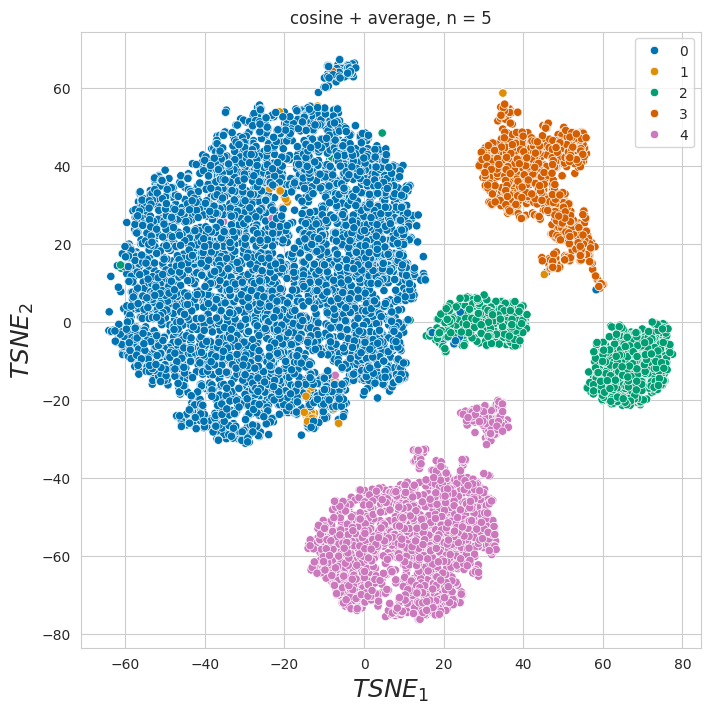

In [46]:
fc_aggl = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='average')
predicted_fc_aggl = fc_aggl.fit_predict(fc_data_final)

plt.figure(figsize=(8, 8))
plt.title('cosine + average, n = 5')
tsne_res_final = plot_tsne(fc_data_final, color=predicted_fc_aggl)

silhouette = silhouette_score(fc_data_final, predicted_fc_aggl)
print(f'Silhouette score: {silhouette}')

In [47]:
# На графике выше чётко отделяются только 4 цвета, плюс дальше видно, что классов 4, так что попробуем тот же алгоритм, но с n=4

Silhouette score: 0.4856221796340132


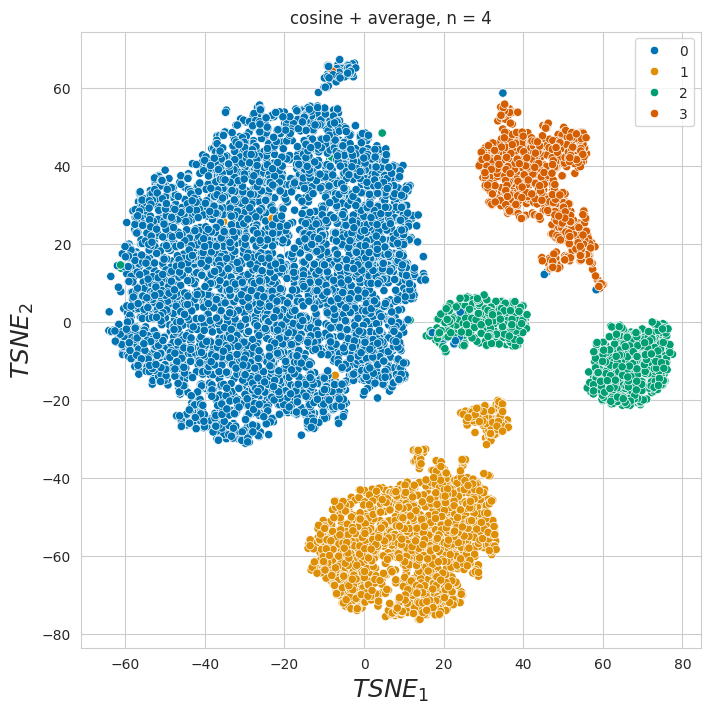

In [48]:
fc_aggl = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average')
predicted_fc_aggl = fc_aggl.fit_predict(fc_data_final)

plt.figure(figsize=(8, 8))
plt.title('cosine + average, n = 4')
tsne_res_final = plot_tsne(fc_data_final, color=predicted_fc_aggl)

silhouette = silhouette_score(fc_data_final, predicted_fc_aggl)
print(f'Silhouette score: {silhouette}')

In [73]:
# На мой взгляд, эта кластеризация выглядит хорошо, но смущает, почему тогда у других комбинаций силуэт выше, а результат хуже

# upd: похоже, это всё из-за сложности наших данных

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

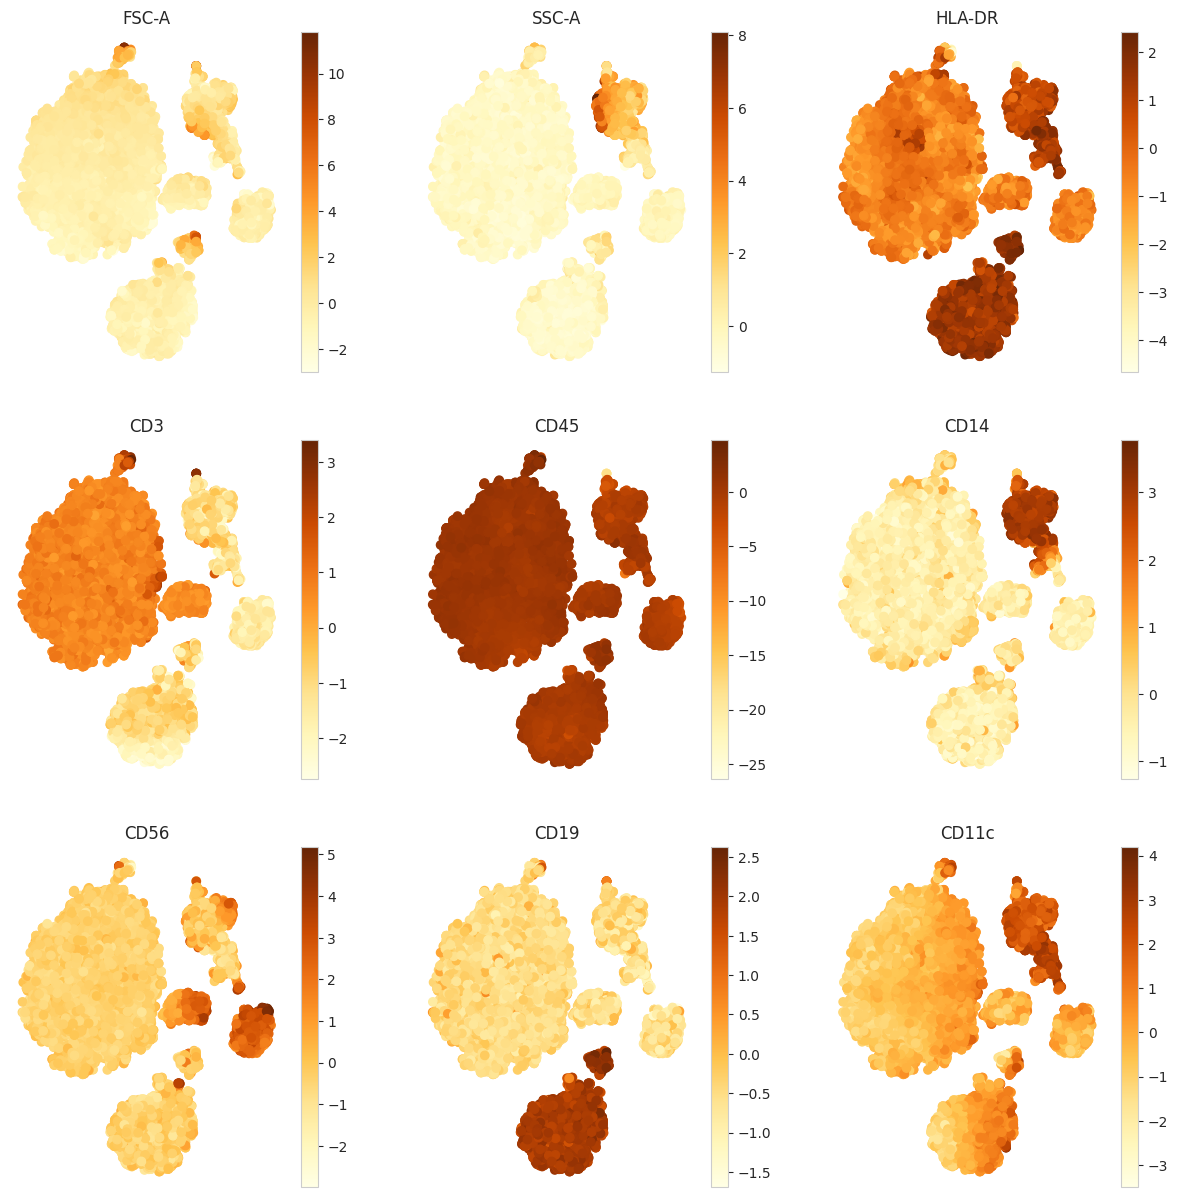

In [50]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for col, ax in zip(fc_data_final.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_final[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [51]:
# CD3 = T-cells
# CD14, CD11c = Monocytes (в одной кучке)
# CD19 = B_cells

cell_type_cluster_map = {0: "T-cells", 
                         1: "B_cells", 
                         2: "Other cells", 
                         3: "Monocytes"}

In [52]:
labeled_fc_data = fc_data_final.assign(Population=fc_aggl.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [53]:
labeled_fc_data.Population.value_counts()

Population
T-cells        5774
B_cells        2038
Monocytes      1098
Other cells    1089
Name: count, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [74]:
# labeled_fc_data.to_csv(join('data', "labeled_fc_data.csv"))

labeled_fc_data.to_csv("../data_folder/processed_data/labeled_flow_c_data.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [55]:
# Knn не совсем подходит в данном случае, т.к. есть дисбаланс классов, а этот алгоритм ориентируется на ближайших соседей => может давать ошибки с классами
# Возможно, здесь лучше подойдет логистическая регрессия

In [75]:
X_train, X_test, y_train, y_test = train_test_split(fc_data_final, 
                                                    labeled_fc_data["Population"], 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [57]:
# данные уже стандартизованы, так что этот шаг пропускаем

In [76]:
model = LogisticRegression(random_state=SEED) # инициализация модели
model.fit(X_train, y_train) # обучение

LogisticRegression(random_state=111)

In [77]:
y_pred = model.predict(X_test) # предсказания на тестовых данных

In [78]:
# оценка качества модели

f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-score: {f1}")

F1-score: 0.9943469991546915


In [61]:
# выглядит как модель хорошего качества
# но мы будем бороться с несбалансированными данными
# попробуем воспользоваться весами классов

In [79]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train) # в классах перечисляем уникальные значения в трейне, 
                                                                                                     # а также указываем весь вектор меток классов трейна

In [80]:
# повторим модель, но уже с учетом весов

model_weighted = LogisticRegression(random_state=SEED, class_weight=dict(zip(np.unique(y_train), class_weights))) # веса в виде словаря, где ключи - уникальные классы, 
                                                                                                                  # а значения - соответствующие веса классов

In [81]:
model_weighted.fit(X_train, y_train)

LogisticRegression(class_weight={'B_cells': 1.2127046694966646,
                                 'Monocytes': 2.277619589977221,
                                 'Other cells': 2.277619589977221,
                                 'T-cells': 0.43529603831084024},
                   random_state=111)

In [82]:
y_pred_weighted = model_weighted.predict(X_test)

In [83]:
f1_weighted = f1_score(y_test, y_pred_weighted, average="macro")
print(f"F1-score with class weights: {f1_weighted}")

F1-score with class weights: 0.9954148491898767


In [84]:
print(f"Ура, теперь качество модели возросло на {f1_weighted - f1}!")

Ура, теперь качество модели возросло на 0.0010678500351851694!


### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Что-то я настолько подзаколебалась за этот февраль, что хочу простого женского навернуть борща и сала. А самый лучший борщ и сало были у меня в одной усадьбе недалеко от Березинского заповедника. Визы всё равно нет, так что будем наслаждаться дарами Беларуси.  

![имя](https://i.postimg.cc/7hNHNHp6/IMG-20210725-142106.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Это дз из всех трёх показалось наиболее сбалансированным(?), по крайней мере на него я потратила внезапно даже чууть-чуть меньше времени, чем на второе и, боже упаси, первое. Будет смешно, если чувство лёгкости ошибочное и на самом деле я просто всё сделала неправильно. We'll see...